In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import feature_extraction

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
import random

In [10]:
# GPU 사용 설정
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"현재 사용 가능한 GPU의 수: {device_count}")
else:
    print("GPU를 사용할 수 없습니다.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

현재 사용 가능한 GPU의 수: 1
cuda


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(2024) # Seed 고정

In [16]:
# 경로 변경
os.chdir(os.getcwd() + '\..\data')

In [20]:
# 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.getcwd() + self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        target = torch.tensor([0.]).float()
        return image, target

# 이미지 전처리 및 임베딩
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CustomDataset(csv_file='./train.csv', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

In [22]:
# ResNet101 모델 로드 및 특징 추출기 생성
resnet_model = models.resnet18(pretrained=True)
# VGG-16 모델을 불러옵니다.
vgg16_model = models.vgg16(pretrained=True)
# VGG-19 모델을 불러옵니다.
vgg19_model = models.vgg19(pretrained=True)
# AlexNet 모델을 불러옵니다.
alexnet_model = models.alexnet(pretrained=True)

# ResNet 모델을 특징 추출기에 전달하여 특징 추출기를 초기화
resnet_feature_extractor = FeatureExtractor(resnet_model).to(device)
# VGG-16 모델을 특징 추출기에 전달하여 특징 추출기를 초기화합니다.
vgg16_feature_extractor = FeatureExtractor(vgg16_model).to(device)
# VGG-19 모델을 특징 추출기에 전달하여 특징 추출기를 초기화합니다.
vgg19_feature_extractor = FeatureExtractor(vgg19_model).to(device)
# AlexNet 모델을 특징 추출기에 전달하여 특징 추출기를 초기화합니다.
alexnet_feature_extractor = FeatureExtractor(alexnet_model).to(device)

# Autoencoder 모델 생성
autoencoder = Autoencoder(input_dim=512, encoding_dim=256).to(device)

c:\Users\dhsmf\anaconda3\envs\ml_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\dhsmf\anaconda3\envs\ml_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
def train_autoencoder(model, train_loader, criterion, optimizer, scheduler, num_epochs=100):
    model.train()
    best_loss = None
    
    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            
            # 특징 추출
            features = feature_extractor(images)
            # Autoencoder를 통한 재구성
            reconstructed = model(features)
            # 재구성 손실 계산
            loss = criterion(reconstructed, features)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # 평균 손실 계산
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
        
        # scheduler.step()에 평균 손실 전달
        scheduler.step(avg_loss)
        
        # Early stopping 조건 확인
        if best_loss is None or avg_loss < best_loss:
            best_loss = avg_loss
        else:
            print("No improvement in loss. Adjusting learning rate...")
            # 학습률 조정 로그는 ReduceLROnPlateau의 verbose=True를 통해 출력됩니다.




# Autoencoder 모델, 손실 함수, 옵티마이저 설정
autoencoder_criterion = nn.MSELoss()
autoencoder_optimizer = optim.AdamW(autoencoder.parameters(), lr=0.001)
autoencoder_scheduler = ReduceLROnPlateau(autoencoder_optimizer, mode='min', factor=0.1, patience=10, verbose=True)


# Autoencoder 모델 학습
train_autoencoder(autoencoder, train_loader, autoencoder_criterion, autoencoder_optimizer,autoencoder_scheduler)

Epoch 1/100, Loss: 0.1449
Epoch 2/100, Loss: 0.0858
Epoch 3/100, Loss: 0.0855
Epoch 4/100, Loss: 0.0850
Epoch 5/100, Loss: 0.0849
Epoch 6/100, Loss: 0.0857
No improvement in loss. Adjusting learning rate...
Epoch 7/100, Loss: 0.0851
No improvement in loss. Adjusting learning rate...
Epoch 8/100, Loss: 0.0856
No improvement in loss. Adjusting learning rate...
Epoch 9/100, Loss: 0.0851
No improvement in loss. Adjusting learning rate...
Epoch 10/100, Loss: 0.0852
No improvement in loss. Adjusting learning rate...
Epoch 11/100, Loss: 0.0854
No improvement in loss. Adjusting learning rate...
Epoch 12/100, Loss: 0.0862
No improvement in loss. Adjusting learning rate...
Epoch 13/100, Loss: 0.0849
No improvement in loss. Adjusting learning rate...
Epoch 14/100, Loss: 0.0854
No improvement in loss. Adjusting learning rate...
Epoch 15/100, Loss: 0.0852
No improvement in loss. Adjusting learning rate...
Epoch 16/100, Loss: 0.0860
Epoch 00016: reducing learning rate of group 0 to 1.0000e-04.
No im

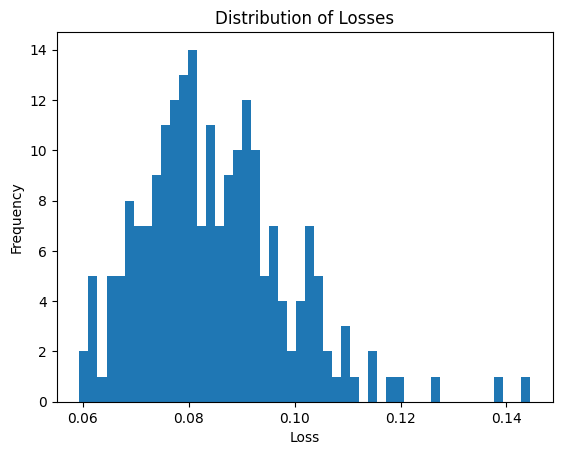

In [24]:
def calculate_losses(train_loader, model):
    model.eval()  # 평가 모드 전환
    losses = []  # 손실 초기화
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            features = feature_extractor(images)
            reconstructed = model(features)
            loss = nn.MSELoss(reduction='none')(reconstructed, features).mean(1)  # 손실 계산
            losses.extend(loss.cpu().numpy())
    return losses

# 학습 데이터의 손실 계산
losses = calculate_losses(train_loader, autoencoder)

# 손실 분포 시각화
plt.hist(losses, bins=50)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Losses')
plt.show()

In [25]:
# 손실 값의 상위 95%에 해당하는 분위수를 임계값으로 설정
threshold = np.quantile(losses, 0.95)
print(f"Threshold for anomaly detection: {threshold}")

Threshold for anomaly detection: 0.10806367546319959


In [26]:
# 테스트 데이터에 대해 이상 탐지 수행
test_data = CustomDataset(csv_file='./test.csv', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 제출 파일 로드
submit = pd.read_csv('./sample_submission.csv')

def detect_anomalies(loader, model, threshold):
    model.eval()
    anomaly_scores = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            features = feature_extractor(images)
            reconstructed = model(features)
            loss = torch.mean((features - reconstructed) ** 2, dim=1)
            anomaly_scores.extend(loss.cpu().numpy())
    return anomaly_scores



# 이상 탐지 수행 및 anomaly_scores 계산
anomaly_scores = detect_anomalies(test_loader, autoencoder, threshold)

# anomaly_scores를 사용하여 정상(0) 또는 이상(1) 레이블 결정
submit['label'] = [1 if score > threshold else 0 for score in anomaly_scores]

# 변경된 submit DataFrame 확인
print(submit.head())

# 결과를 CSV 파일로 저장
submit.to_csv('.result.csv', index=False)

         id  label
0  TEST_000      0
1  TEST_001      0
2  TEST_002      0
3  TEST_003      0
4  TEST_004      0
